In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

!ls /kaggle/input/

# Any results you write to the current directory are saved as output.

e059-question			      google-quest-e047-e030-answer-only
e060-answer			      guchio-quest-e002
google-quest-challenge		      guchio-transformers
google-quest-e030-head-tail	      sacremoses-master
google-quest-e046-e030-question-only  transformers


In [2]:
!ls /kaggle/input/e059-question

added_tokens.json  optRs.pkl		    tokenizer_config.json
best_dict.pth	   special_tokens_map.json  vocab.txt


In [3]:
!ls /kaggle/input/google-quest-e030-head-tail

added_tokens.json  optRs.pkl		    tokenizer_config.json
best_dict.pth	   special_tokens_map.json  vocab.txt


In [4]:
import os

def OSprint(string):
    os.system(f'echo \"{string}\"')
    print(string)

In [5]:
NUM_FOLDS = 5
DEVICE = 'cuda'
#DEVICE = 'cpu'
BATCH_SIZE = 8

In [6]:
!pip install /kaggle/input/sacremoses-master/sacremoses > /dev/null
#!pip install /kaggle/input/transformers/transformers-master #> /dev/null
!pip install --no-deps /kaggle/input/guchio-transformers/*.whl #> /dev/null

Processing /kaggle/input/guchio-transformers/boto3-1.10.46-py2.py3-none-any.whl
Processing /kaggle/input/guchio-transformers/botocore-1.13.46-py2.py3-none-any.whl
Processing /kaggle/input/guchio-transformers/certifi-2019.11.28-py2.py3-none-any.whl
Processing /kaggle/input/guchio-transformers/joblib-0.14.1-py2.py3-none-any.whl
Processing /kaggle/input/guchio-transformers/numpy-1.18.0-cp36-cp36m-manylinux1_x86_64.whl
Processing /kaggle/input/guchio-transformers/python_dateutil-2.8.1-py2.py3-none-any.whl
Processing /kaggle/input/guchio-transformers/regex-2019.12.20-cp36-cp36m-manylinux2010_x86_64.whl
Processing /kaggle/input/guchio-transformers/sentencepiece-0.1.85-cp36-cp36m-manylinux1_x86_64.whl
Processing /kaggle/input/guchio-transformers/tqdm-4.41.1-py2.py3-none-any.whl
Processing /kaggle/input/guchio-transformers/transformers-2.3.0-py3-none-any.whl
Processing /kaggle/input/guchio-transformers/urllib3-1.25.7-py2.py3-none-any.whl
  Found existing installation: boto3 1.10.29
    Uninsta

In [7]:
import transformers
from transformers import BertModel

In [8]:
model = BertModel.from_pretrained('/kaggle/input/guchio-quest-e002')

In [9]:
import torch

# best_dict = torch.load('/kaggle/input/google-quest-e046-e030-question-only/best_dict.pth')

In [10]:
test_df = pd.read_csv('/kaggle/input/google-quest-challenge/test.csv')

In [11]:
import random
from math import ceil, floor
import pandas as pd
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

from transformers import BertTokenizer


def seed_everything(seed=71):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything()


# --- dataset ---
class QUESTDataset(Dataset):
    def __init__(self, df, mode, tokens, augment,
                 pretrained_model_name_or_path, TBSEP='[TBSEP]',
                 MAX_SEQUENCE_LENGTH=None, use_category=True, logger=None,
                 t_max_len=30, q_max_len=239, a_max_len=239):
        self.t_max_len = t_max_len
        self.q_max_len = q_max_len
        self.a_max_len = a_max_len
        
        self.mode = mode
        self.augment = augment
        self.len = len(df)
        self.TBSEP = TBSEP
        if MAX_SEQUENCE_LENGTH:
            self.MAX_SEQUENCE_LENGTH = MAX_SEQUENCE_LENGTH
        else:
            raise NotImplementedError
            # self.MAX_SEQUENCE_LENGTH = -1
            # for i, row in self.prep_df.iterrows():
            #     input_ids = row['input_ids'].squeeze()
            #     if self.MAX_SEQUENCE_LENGTH < len(input_ids):
            #         self.MAX_SEQUENCE_LENGTH = len(input_ids)
            # sel_log(f'calculated seq_len: {self.MAX_SEQUENCE_LENGTH}', logger)
        self.use_category = use_category
        self.logger = logger
        self.cat_dict = {
            'CAT_TECHNOLOGY'.casefold(): 0,
            'CAT_STACKOVERFLOW'.casefold(): 1,
            'CAT_CULTURE'.casefold(): 2,
            'CAT_SCIENCE'.casefold(): 3,
            'CAT_LIFE_ARTS'.casefold(): 4,
        }

        if mode == "test":
            self.labels = pd.DataFrame([[-1] * 21] * len(df))
        else:  # train or valid
            self.labels = df.iloc[:, 11:]

        self.tokenizer = BertTokenizer.from_pretrained(
            pretrained_model_name_or_path)
        # self.tokenizer.add_special_tokens(
        #     {'additional_special_tokens': [self.TBSEP]})
        self.tokenizer.add_tokens([self.TBSEP])

        tokens = [token.encode('ascii', 'replace').decode()
                  for token in tokens if token != '']
        added_num = self.tokenizer.add_tokens(tokens)
        if logger:
            logger.info(f'additional_tokens : {added_num}')
        else:
            print(f'additional_tokens : {added_num}')
        # change online preprocess or off line preprocess
        self.original_df = df
        # res = self._preprocess_texts(df)
        # self.prep_df = df.merge(pd.DataFrame(res), on='qa_id', how='left')

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        # change online preprocess or off line preprocess
        # idx_row = self.prep_df.iloc[idx]
        idx_row = self.original_df.iloc[idx].copy()
        # idx_row = self._augment(idx_row)
        idx_row = self.__preprocess_text_row(idx_row,
                                             t_max_len=self.t_max_len,
                                             q_max_len=self.q_max_len,
                                             a_max_len=self.a_max_len)
                                             # t_max_len=30,
                                             # q_max_len=239,
                                             # a_max_len=239)
                                             # t_max_len=100,
                                             # q_max_len=700,
                                             # a_max_len=700)
        input_ids = idx_row['input_ids'].squeeze()
        token_type_ids = idx_row['token_type_ids'].squeeze()
        attention_mask = idx_row['attention_mask'].squeeze()
        qa_id = idx_row['qa_id'].squeeze()
        # cat_labels = idx_row['cat_label'].squeeze()
        cat_labels = -1
        position_ids = torch.arange(self.MAX_SEQUENCE_LENGTH)

        labels = self.labels.iloc[idx].values
        return qa_id, input_ids, attention_mask, \
            token_type_ids, cat_labels, position_ids, labels

    def _trim_input(self, title, question, answer,
                    t_max_len, q_max_len, a_max_len):

        t_len = len(title)
        q_len = len(question)
        a_len = len(answer)

        if (t_len + q_len + a_len + 4) > self.MAX_SEQUENCE_LENGTH:
            if t_max_len > t_len:
                t_new_len = t_len
                a_max_len = a_max_len + floor((t_max_len - t_len) / 2)
                q_max_len = q_max_len + ceil((t_max_len - t_len) / 2)
            else:
                t_new_len = t_max_len

            if a_max_len > a_len:
                a_new_len = a_len
                q_new_len = q_max_len + (a_max_len - a_len)
            elif q_max_len > q_len:
                a_new_len = a_max_len + (q_max_len - q_len)
                q_new_len = q_len
            else:
                a_new_len = a_max_len
                q_new_len = q_max_len

            # if t_new_len + a_new_len + q_new_len + 4 != self.MAX_SEQUENCE_LENGTH:
            #     raise ValueError("New sequence length should be %d, but is %d"
            #                      % (self.MAX_SEQUENCE_LENGTH,
            #                          (t_new_len + a_new_len + q_new_len + 4)))
            if len(title) > t_new_len:
                title = title[:t_new_len//2] + title[-t_new_len//2:]
            else:
                title = title[:t_new_len]
            if len(question) > q_new_len:
                question = question[:q_new_len//2] + question[-q_new_len//2:]
            else:
                question = question[:q_new_len]
            if len(answer) > a_new_len:
                answer = answer[:a_new_len//2] + answer[-a_new_len//2:]
            else:
                answer = answer[:a_new_len]
        return title, question, answer

    def __preprocess_text_row(self, row, t_max_len, q_max_len, a_max_len):
        qa_id = row.qa_id
#        title = self.tokenizer.tokenize(row.question_title)
#        body = self.tokenizer.tokenize(row.question_body)
#        answer = self.tokenizer.tokenize(row.answer.casefold())
        title = self.tokenizer.tokenize(row.question_title)
        body = self.tokenizer.tokenize(row.question_body)
        answer = self.tokenizer.tokenize(row.answer)
#        title = row.question_title.casefold()
#        body = row.question_body.casefold()
#        answer = row.answer.casefold()
#        category = row.category
        category = ('CAT_' + row.category).casefold()

        # category $B$r(B text $B$H$7$FF~$l$F$7$^$&(B !!!
        if self.use_category:
            title = [category] + title

        title, body, answer = self._trim_input(title, body, answer,
                                               t_max_len=t_max_len,
                                               q_max_len=q_max_len,
                                               a_max_len=a_max_len)

        title_and_body = title + [self.TBSEP] + body
        # title_and_body = title + f' {self.TBSEP} ' + body

        encoded_texts_dict = self.tokenizer.encode_plus(
            text=title_and_body,
            text_pair=answer,
            add_special_tokens=True,
            max_length=self.MAX_SEQUENCE_LENGTH,
            pad_to_max_length=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
            return_overflowing_tokens=True,
        )
        encoded_texts_dict['qa_id'] = qa_id
        encoded_texts_dict['cat_label'] = self.cat_dict[category]
        return encoded_texts_dict

    def _preprocess_texts(self, df):
        '''
        could be multi-processed if you need speeding up
        '''
        res = []
        for i, row in tqdm(list(df.iterrows())):
            res.append(self.__preprocess_text_row(row))
        return res

In [12]:
import torch
from torch import nn

from transformers import BertModel


class BertModelForBinaryMultiLabelClassifier(nn.Module):
    def __init__(self, num_labels, pretrained_model_name_or_path=None,
                 cat_num=0, token_size=None, MAX_SEQUENCE_LENGTH=512):
        super(BertModelForBinaryMultiLabelClassifier, self).__init__()
        if pretrained_model_name_or_path:
            self.model = BertModel.from_pretrained(
                pretrained_model_name_or_path)
        else:
            raise NotImplementedError
        self.num_labels = num_labels
        if cat_num > 0:
            self.catembedding = nn.Embedding(cat_num, 768)
            self.catdropout = nn.Dropout(0.2)
            self.catactivate = nn.ReLU()

            self.catembeddingOut = nn.Embedding(cat_num, cat_num // 2 + 1)
            self.catactivateOut = nn.ReLU()
            self.dropout = nn.Dropout(0.2)
            self.classifier = nn.Linear(
                self.model.pooler.dense.out_features + cat_num // 2 + 1, num_labels)
        else:
            self.catembedding = None
            self.catdropout = None
            self.catactivate = None
            self.catembeddingOut = None
            self.catactivateOut = None
            self.dropout = nn.Dropout(0.2)
            self.classifier = nn.Linear(
                self.model.pooler.dense.out_features, num_labels)

        # resize
        if token_size:
            self.model.resize_token_embeddings(token_size)

        # define input embedding and transformers
        self.model.embeddings.position_embeddings = self._resize_embeddings(
            self.model.embeddings.position_embeddings, MAX_SEQUENCE_LENGTH)

        # use bertmodel as decoder
        # self.model.config.is_decoder = True

        # add modules
        # self.add_module('my_input_embeddings', self.input_embeddings)
        # self.add_module('my_input_bert_layer', self.input_bert_layer)
        # self.add_module('fc_output', self.classifier)

    def forward(self, input_ids=None, input_cats=None, labels=None, attention_mask=None,
                token_type_ids=None, position_ids=None, head_mask=None,
                inputs_embeds=None, encoder_hidden_states=None,
                encoder_attention_mask=None):
        if self.catembedding:
            raise NotImplementedError
            # encoder_hidden_states = self.catembedding(input_cats)
            # encoder_hidden_states = self.catdropout(encoder_hidden_states)
            # encoder_hidden_states = self.catactivate(encoder_hidden_states)
        # if input_cats or inputs_embeds or encoder_hidden_states or encoder_attention_mask:
        #     raise NotImplementedError

        # embedding_output = self.input_embeddings(
        #     input_ids=input_ids,
        #     position_ids=position_ids,
        #     token_type_ids=token_type_ids,
        #     inputs_embeds=inputs_embeds)
        # layer_output = self.input_bert_layer(embedding_output)
        # inputs_embeds = layer_output[0]  # fit to bertmodel

        # outputs = self.model(input_ids=input_ids_2[:, :512],
        outputs = self.model(input_ids=input_ids,
                             # attention_mask=attention_mask[:, :512],
                             attention_mask=attention_mask,
                             # token_type_ids=token_type_ids[:, :512],
                             token_type_ids=token_type_ids,
                             position_ids=None,
                             head_mask=None,
                             # inputs_embeds=inputs_embeds[:, :512, :],
                             inputs_embeds=None,
                             # encoder_hidden_states=inputs_embeds,
                             encoder_hidden_states=None,
                             encoder_attention_mask=None)
        # pooled_output = outputs[1]
        pooled_output = torch.mean(outputs[0], dim=1)
        if self.catembeddingOut:
            outcat = self.catembeddingOut(input_cats)
            outcat = self.catactivateOut(outcat)
            pooled_output = torch.cat([pooled_output, outcat], -1)

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        # add hidden states and attention if they are here
        outputs = (logits,) + outputs[2:]

        return outputs  # logits, (hidden_states), (attentions)

    def resize_token_embeddings(self, token_num):
        self.model.resize_token_embeddings(token_num)

    def freeze_unfreeze_bert(self, freeze=True, logger=None):
        if freeze:
            sel_log('FREEZE bert model !', logger)
            # for name, child in self.model.module.named_children():
            for name, child in self.model.named_children():
                for param in child.parameters():
                    param.requires_grad = False
        else:
            sel_log('UNFREEZE bert model !', logger)
            # for name, child in self.model.module.named_children():
            for name, child in self.model.named_children():
                for param in child.parameters():
                    param.requires_grad = True

    def _resize_embeddings(self, old_embeddings, new_num_tokens):
        old_num_tokens, old_embedding_dim = old_embeddings.weight.size()
        if old_num_tokens == new_num_tokens:
            return old_embeddings

        # Build new embeddings
        new_embeddings = nn.Embedding(new_num_tokens, old_embedding_dim)
        new_embeddings.to(old_embeddings.weight.device)

        # Copy word embeddings from the previous weights
        num_tokens_to_copy = min(old_num_tokens, new_num_tokens)
        new_embeddings.weight.data[:num_tokens_to_copy,
                                   :] = old_embeddings.weight.data[:num_tokens_to_copy, :]

        return new_embeddings

In [13]:
def test(model, loader, tta=False):
    model.eval()

    with torch.no_grad():
        y_preds, qa_ids = [], []

        running_loss = 0
        for (qa_id, input_ids, attention_mask,
             token_type_ids, cat_labels, position_ids, labels) in tqdm(loader):
            # send them to DEVICE
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            token_type_ids = token_type_ids.to(DEVICE)
            labels = labels.to(DEVICE)

            # forward
            outputs = model(
                input_ids=input_ids,
                labels=labels,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
            )
            logits = outputs[0]
#            loss = soft_binary_cross_entropy(logits, labels)

#            running_loss += loss

            y_preds.append(nn.functional.sigmoid(logits))
#            y_trues.append(labels)
            qa_ids.append(qa_id)

#        loss_mean = running_loss / len(loader)

        y_preds = torch.cat(y_preds).to('cpu').numpy()
#        y_trues = torch.cat(y_trues).to('cpu').numpy()
        qa_ids = torch.cat(qa_ids).to('cpu').numpy()

#        metric = compute_spearmanr(y_trues, y_preds)

    return y_preds, qa_ids

In [14]:
OSprint('start training!')

start training!


In [15]:
#%debug
# prediction_loop
import os
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler


fold_prediction_dict = {}

best_dict = torch.load('/kaggle/input/e059-question/best_dict.pth')
for fold in range(5):
    OSprint(f'fold -- {fold}')
    model = BertModelForBinaryMultiLabelClassifier(21, '/kaggle/input/guchio-quest-e002', token_size=30528, )
    
    model.load_state_dict(best_dict[fold])
    model = model.to(DEVICE)
    
    test_dataset = QUESTDataset(
        df=test_df,
        mode='test',
        augment=[],
#        pretrained_model_name_or_path='/kaggle/input/guchio-quest-e002',
        pretrained_model_name_or_path='/kaggle/input/e059-question',
        tokens = [
            'CAT_TECHNOLOGY'.casefold(),
            'CAT_STACKOVERFLOW'.casefold(),
            'CAT_CULTURE'.casefold(),
            'CAT_SCIENCE'.casefold(),
            'CAT_LIFE_ARTS'.casefold(),
        ],
        MAX_SEQUENCE_LENGTH=512,
        t_max_len=30, q_max_len=239*2, a_max_len=239*0
    )
    test_sampler = RandomSampler(data_source=test_dataset)
    test_loader = DataLoader(
            test_dataset,
            batch_size=BATCH_SIZE,
            sampler=test_sampler,
            num_workers=os.cpu_count(),
            worker_init_fn=lambda x: np.random.seed(),
            drop_last=False,
            pin_memory=True
        )
    
    y_preds, qa_ids = test(model, test_loader)
    
    fold_df = pd.DataFrame(y_preds)
    fold_df['qa_id'] = qa_ids
    fold_prediction_dict[fold] = fold_df

    
    
best_dict = torch.load('/kaggle/input/e060-answer/best_dict.pth')
for fold in range(5):
    OSprint(f'fold -- {fold}')
    model = BertModelForBinaryMultiLabelClassifier(9, '/kaggle/input/guchio-quest-e002', token_size=30528, )
    
    model.load_state_dict(best_dict[fold])
    model = model.to(DEVICE)
    
    test_dataset = QUESTDataset(
        df=test_df,
        mode='test',
        augment=[],
#        pretrained_model_name_or_path='/kaggle/input/guchio-quest-e002',
        pretrained_model_name_or_path='/kaggle/input/e060-answer',
        tokens = [
            'CAT_TECHNOLOGY'.casefold(),
            'CAT_STACKOVERFLOW'.casefold(),
            'CAT_CULTURE'.casefold(),
            'CAT_SCIENCE'.casefold(),
            'CAT_LIFE_ARTS'.casefold(),
        ],
        MAX_SEQUENCE_LENGTH=512,
        t_max_len=30, q_max_len=239*0, a_max_len=239*2
    )
    test_sampler = RandomSampler(data_source=test_dataset)
    test_loader = DataLoader(
            test_dataset,
            batch_size=BATCH_SIZE,
            sampler=test_sampler,
            num_workers=os.cpu_count(),
            worker_init_fn=lambda x: np.random.seed(),
            drop_last=False,
            pin_memory=True
        )
    
    y_preds, qa_ids = test(model, test_loader)
    
    fold_df = pd.DataFrame(y_preds)
    fold_df['qa_id'] = qa_ids
    fold_prediction_dict[fold] = fold_prediction_dict[fold].merge(fold_df, on='qa_id', how='left')

fold -- 0
additional_tokens : 0


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



fold -- 1
additional_tokens : 0



fold -- 2
additional_tokens : 0



fold -- 3
additional_tokens : 0



fold -- 4
additional_tokens : 0



fold -- 0
additional_tokens : 0



fold -- 1
additional_tokens : 0



fold -- 2
additional_tokens : 0



fold -- 3
additional_tokens : 0



fold -- 4
additional_tokens : 0


In [16]:
# {v: k for k, v in test_dataset.tokenizer.vocab.items()}[30527]

In [17]:
def convert_folds_prediction_to_sub(folds_prediction_dict):
    for i, fold in enumerate(folds_prediction_dict):
        if i == 0:
            prediction = folds_prediction_dict[fold].sort_values('qa_id').set_index('qa_id').values
        else:
            prediction += folds_prediction_dict[fold].sort_values('qa_id').set_index('qa_id').values
#    sub_df = pd.DataFrame(base_prediction)
#    sub_df['qa_id'] = folds_prediction_dict[fold]['qa_id'].sort_values().values
    prediction /= len(folds_prediction_dict)
    return prediction

In [18]:
prediction = convert_folds_prediction_to_sub(fold_prediction_dict)

In [19]:
raw_prediction = prediction.copy()

## opt

In [20]:
import pickle
from functools import partial
from glob import glob

import numpy as np
import pandas as pd
import scipy as sp
import torch
from scipy.stats import spearmanr
from tqdm import tqdm

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """

    def __init__(self):
        self.coef_ = 0

    def _spearmanr_loss(self, coef, X, y, labels):
        """
        Get loss according to
        using current coefficients
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                     [np.inf], labels=labels)

        # return -np.mean(spearmanr(y, X_p).correlation)
        return -spearmanr(y, X_p).correlation

    def fit(self, X, y, initial_coef):
        """
        Optimize rounding thresholds
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        labels = self.labels
        loss_partial = partial(self._spearmanr_loss, X=X, y=y, labels=labels)
        self.coef_ = sp.optimize.minimize(
            loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        labels = self.labels
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                      [np.inf], labels=labels)
        # [np.inf], labels=[0, 1, 2, 3])

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

    def set_labels(self, labels):
        self.labels = labels

In [21]:
with open('/kaggle/input/e059-question/optRs.pkl', 'rb') as fin:
    optRs = pickle.load(fin)
with open('/kaggle/input/e060-answer/optRs.pkl', 'rb') as fin:
    optRs += pickle.load(fin)    

In [22]:
res_prediction = []
for i in tqdm(list(range(30))):
    y_pred = prediction[:, i]
    #y_pred_argmax = np.argmax(y_pred)
    #y_pred_argmin = np.argmin(y_pred)
    if i not in [2,4,5,6,7,11,12,13,14,15,16,18,19,29]:
    #if i not in [2,4,5,6,7,11,12,13,14,15,19,21,22,23,24,25,29]:
        res_prediction.append(y_pred)
        continue
    
    optR = optRs[i]
    res = optR.predict(y_pred, optR.coefficients()).astype(float)

    #if len(np.unique(res)) == 1:
    #    if np.unique(res)[0] == res[y_pred_argmax]:
    #        res[y_pred_argmin] = np.min(y_pred)
    #    elif np.unique(res)[0] == res[y_pred_argmin]:
    #        if np.unique(res)[0] > 0.5:
    #            res[y_pred_argmin] = 0
    #        else:
    #            res[y_pred_argmax] = 1                
    #    else:
    #        res[y_pred_argmax] = np.max(y_pred)

    res_prediction.append(res)

prediction = np.asarray(res_prediction).T

100%|██████████| 30/30 [00:00<00:00, 1351.33it/s]


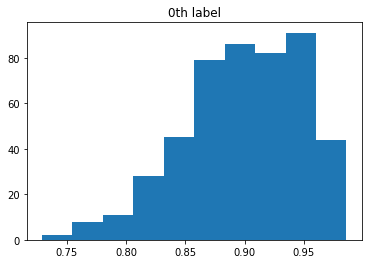

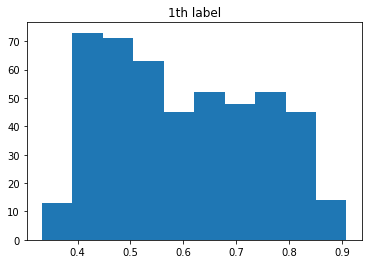

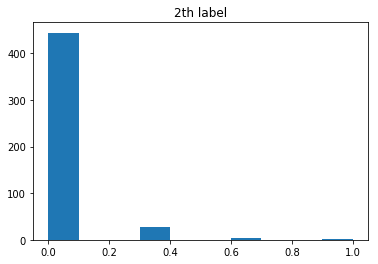

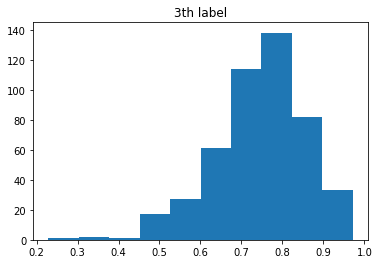

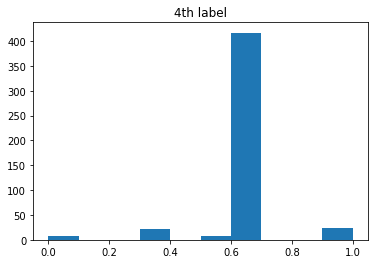

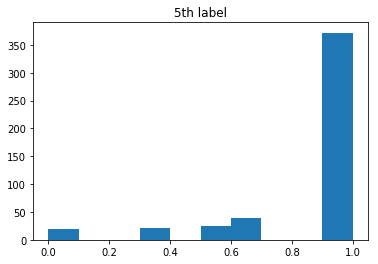

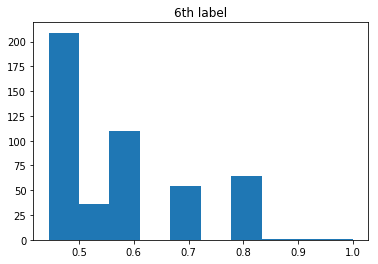

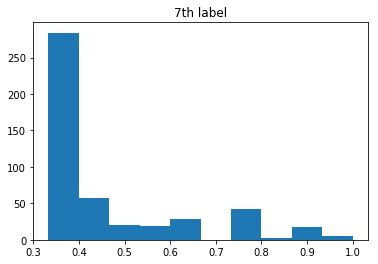

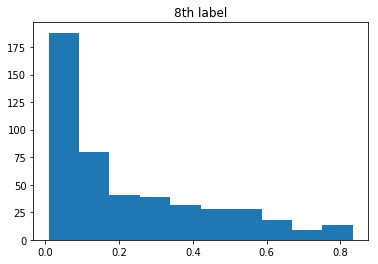

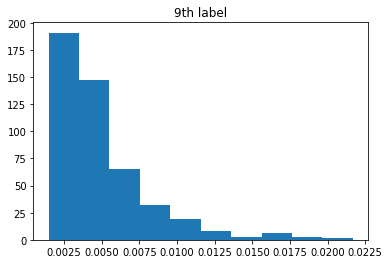

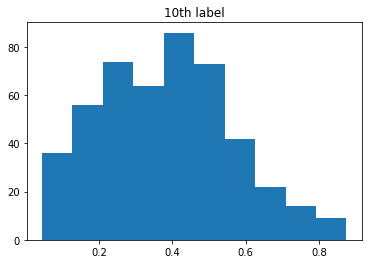

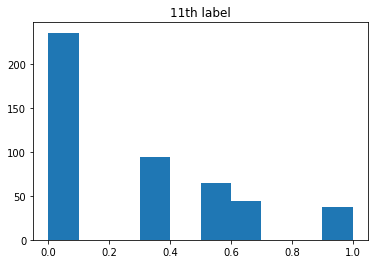

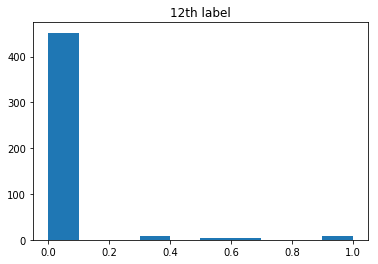

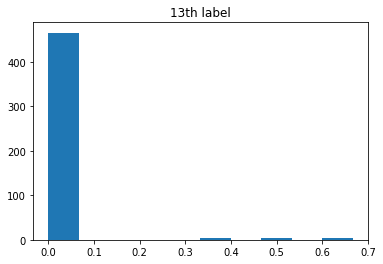

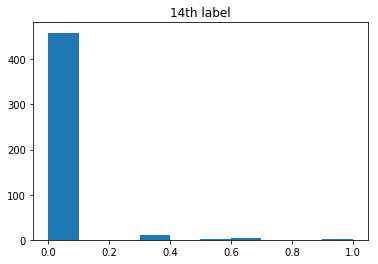

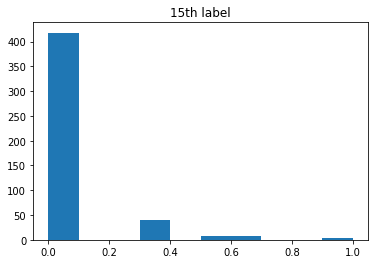

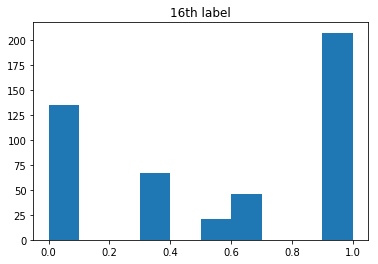

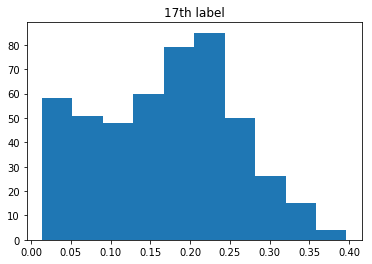

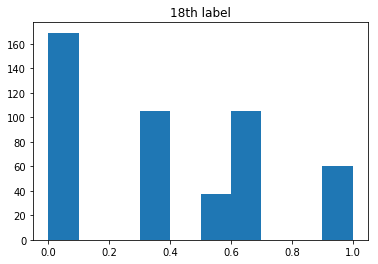

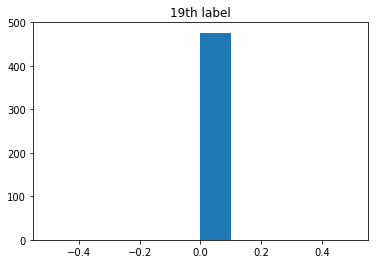

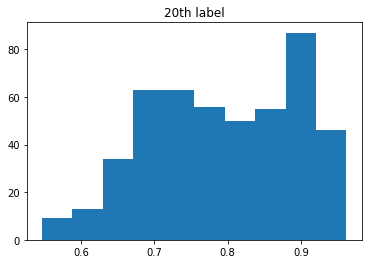

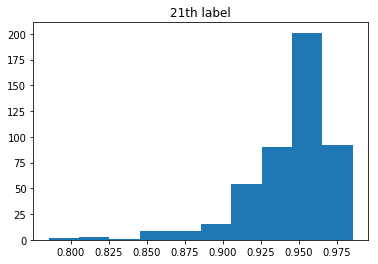

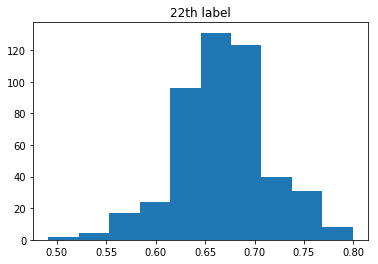

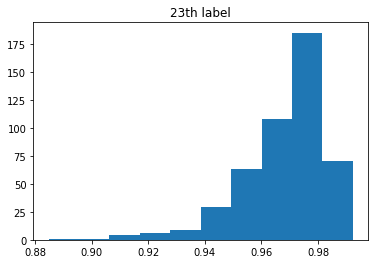

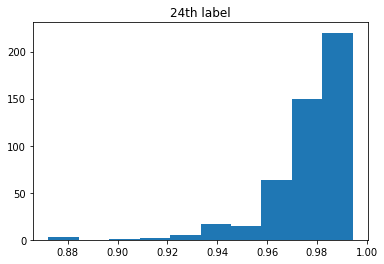

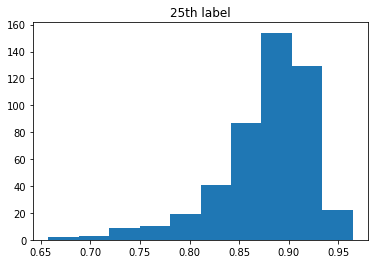

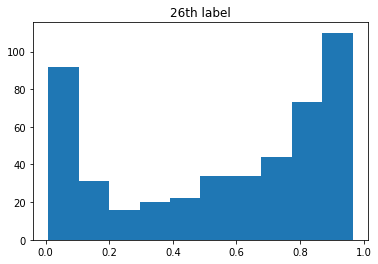

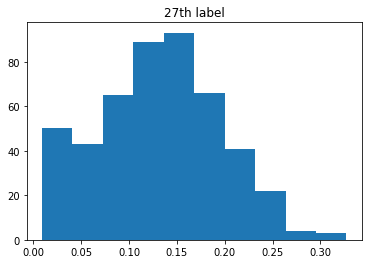

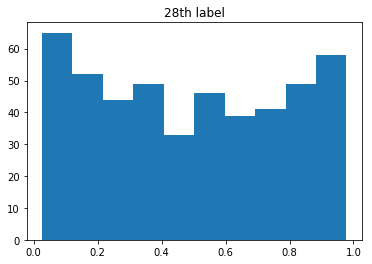

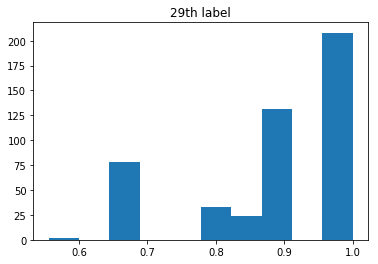

In [23]:
from matplotlib import pyplot as plt

for i in range(30):
    plt.hist(prediction[:, i])
    plt.title(f'{i}th label')
    plt.show()

In [24]:
sub_df = pd.read_csv('/kaggle/input/google-quest-challenge/sample_submission.csv')
sub_df.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,...,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308
1,46,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,...,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448
2,70,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,...,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673
3,132,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,...,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401
4,200,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,...,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074


In [25]:
sub_df.iloc[:, 1:] = prediction
sub_df.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.953836,0.624842,0.333333,0.617083,0.500000,0.333333,0.777778,0.777778,0.621079,...,0.918724,0.931793,0.594564,0.969633,0.971676,0.838887,0.086542,0.036111,0.891839,1.000000
1,46,0.892057,0.501624,0.000000,0.805128,0.666667,1.000000,0.500000,0.444444,0.106353,...,0.666314,0.963806,0.675119,0.978827,0.987381,0.900468,0.928894,0.115464,0.083098,0.833333
2,70,0.923208,0.663256,0.000000,0.836724,0.666667,1.000000,0.555556,0.444444,0.125562,...,0.855214,0.950350,0.614907,0.976424,0.981210,0.869838,0.131263,0.079894,0.902577,0.888889
3,132,0.880613,0.432558,0.000000,0.718054,0.666667,1.000000,0.444444,0.333333,0.070246,...,0.695647,0.968827,0.712024,0.977684,0.988630,0.916424,0.865850,0.170171,0.563674,0.888889
4,200,0.915054,0.405765,0.000000,0.878668,0.666667,1.000000,0.666667,0.777778,0.039480,...,0.570336,0.926950,0.675484,0.971833,0.972566,0.862080,0.144606,0.105491,0.481328,0.888889


## avoid scoring error

In [26]:
pub_qa_id = [39, 46, 70, 132, 200, 245, 257, 267, 284, 292, 296, 312, 322, 327, 334, 340, 357, 374, 375, 387, 391, 395, 444, 482, 483, 513, 542, 579, 589, 625, 641, 683, 725, 727, 728, 740, 748, 765, 811, 830, 851, 856, 885, 905, 929, 938, 939, 962, 1082, 1091, 1101, 1119, 1153, 1226, 1230, 1238, 1247, 1249, 1266, 1282, 1297, 1331, 1359, 1398, 1423, 1477, 1502, 1544, 1567, 1654, 1676, 1700, 1701, 1727, 1764, 1794, 1795, 1807, 1812, 1816, 1833, 1847, 1868, 1877, 1885, 1934, 1959, 1983, 1990, 2005, 2018, 2027, 2042, 2066, 2070, 2075, 2094, 2128, 2163, 2180, 2203, 2230, 2244, 2257, 2277, 2278, 2286, 2303, 2335, 2374, 2387, 2395, 2455, 2465, 2474, 2487, 2493, 2534, 2569, 2573, 2580, 2592, 2607, 2621, 2655, 2666, 2669, 2670, 2676, 2691, 2748, 2763, 2774, 2789, 2793, 2795, 2797, 2806, 2844, 2868, 2895, 2912, 2922, 2931, 2968, 3034, 3062, 3087, 3107, 3173, 3207, 3229, 3290, 3336, 3378, 3399, 3437, 3461, 3463, 3502, 3504, 3524, 3526, 3527, 3532, 3543, 3544, 3560, 3592, 3671, 3682, 3696, 3720, 3787, 3854, 3871, 3876, 3881, 3901, 3941, 3943, 3949, 3961, 3962, 3967, 4006, 4039, 4057, 4070, 4099, 4139, 4157, 4160, 4176, 4182, 4183, 4211, 4213, 4250, 4263, 4269, 4281, 4284, 4285, 4286, 4346, 4387, 4388, 4401, 4416, 4441, 4497, 4546, 4547, 4564, 4569, 4575, 4598, 4607, 4663, 4679, 4743, 4751, 4778, 4792, 4835, 4881, 4901, 4954, 4973, 5001, 5003, 5019, 5035, 5050, 5057, 5076, 5091, 5095, 5141, 5152, 5253, 5367, 5373, 5403, 5417, 5422, 5499, 5503, 5530, 5541, 5542, 5660, 5663, 5697, 5753, 5783, 5790, 5835, 5847, 5862, 5878, 5891, 5904, 5907, 5914, 5936, 5947, 5958, 5972, 5979, 5998, 6016, 6042, 6058, 6079, 6087, 6111, 6126, 6132, 6159, 6204, 6212, 6226, 6258, 6271, 6280, 6285, 6301, 6319, 6325, 6331, 6332, 6336, 6346, 6378, 6379, 6420, 6445, 6481, 6494, 6495, 6502, 6560, 6580, 6583, 6621, 6643, 6646, 6688, 6694, 6715, 6723, 6737, 6744, 6745, 6766, 6770, 6774, 6821, 6832, 6838, 6856, 6888, 6889, 6955, 6957, 6964, 6988, 6994, 7012, 7018, 7036, 7064, 7072, 7114, 7116, 7123, 7150, 7165, 7176, 7194, 7201, 7216, 7247, 7254, 7272, 7278, 7281, 7293, 7302, 7326, 7404, 7410, 7438, 7477, 7481, 7485, 7519, 7520, 7525, 7531, 7544, 7546, 7589, 7595, 7614, 7640, 7654, 7672, 7711, 7727, 7739, 7758, 7766, 7815, 7838, 7852, 7869, 7878, 7899, 7935, 7939, 7970, 8021, 8032, 8045, 8070, 8089, 8115, 8143, 8146, 8191, 8197, 8206, 8212, 8242, 8245, 8250, 8258, 8271, 8273, 8339, 8350, 8355, 8376, 8395, 8412, 8427, 8437, 8464, 8496, 8516, 8517, 8551, 8564, 8591, 8621, 8626, 8629, 8672, 8684, 8685, 8690, 8738, 8755, 8756, 8760, 8771, 8773, 8778, 8823, 8834, 8842, 8846, 8875, 8916, 8921, 8932, 8934, 8938, 8973, 8987, 9001, 9006, 9018, 9033, 9065, 9140, 9141, 9174, 9213, 9225, 9228, 9237, 9240, 9256, 9259, 9263, 9298, 9324, 9350, 9391, 9400, 9439, 9454, 9476, 9478, 9497, 9545, 9567, 9569, 9590, 9597, 9623, 9640]
# pub_qa_id = [70, 132, 200, 245, 257, 267, 284, 292, 296, 312, 322, 327, 334, 340, 357, 374, 375, 387, 391, 395, 444, 482, 483, 513, 542, 579, 589, 625, 641, 683, 725, 727, 728, 740, 748, 765, 811, 830, 851, 856, 885, 905, 929, 938, 939, 962, 1082, 1091, 1101, 1119, 1153, 1226, 1230, 1238, 1247, 1249, 1266, 1282, 1297, 1331, 1359, 1398, 1423, 1477, 1502, 1544, 1567, 1654, 1676, 1700, 1701, 1727, 1764, 1794, 1795, 1807, 1812, 1816, 1833, 1847, 1868, 1877, 1885, 1934, 1959, 1983, 1990, 2005, 2018, 2027, 2042, 2066, 2070, 2075, 2094, 2128, 2163, 2180, 2203, 2230, 2244, 2257, 2277, 2278, 2286, 2303, 2335, 2374, 2387, 2395, 2455, 2465, 2474, 2487, 2493, 2534, 2569, 2573, 2580, 2592, 2607, 2621, 2655, 2666, 2669, 2670, 2676, 2691, 2748, 2763, 2774, 2789, 2793, 2795, 2797, 2806, 2844, 2868, 2895, 2912, 2922, 2931, 2968, 3034, 3062, 3087, 3107, 3173, 3207, 3229, 3290, 3336, 3378, 3399, 3437, 3461, 3463, 3502, 3504, 3524, 3526, 3527, 3532, 3543, 3544, 3560, 3592, 3671, 3682, 3696, 3720, 3787, 3854, 3871, 3876, 3881, 3901, 3941, 3943, 3949, 3961, 3962, 3967, 4006, 4039, 4057, 4070, 4099, 4139, 4157, 4160, 4176, 4182, 4183, 4211, 4213, 4250, 4263, 4269, 4281, 4284, 4285, 4286, 4346, 4387, 4388, 4401, 4416, 4441, 4497, 4546, 4547, 4564, 4569, 4575, 4598, 4607, 4663, 4679, 4743, 4751, 4778, 4792, 4835, 4881, 4901, 4954, 4973, 5001, 5003, 5019, 5035, 5050, 5057, 5076, 5091, 5095, 5141, 5152, 5253, 5367, 5373, 5403, 5417, 5422, 5499, 5503, 5530, 5541, 5542, 5660, 5663, 5697, 5753, 5783, 5790, 5835, 5847, 5862, 5878, 5891, 5904, 5907, 5914, 5936, 5947, 5958, 5972, 5979, 5998, 6016, 6042, 6058, 6079, 6087, 6111, 6126, 6132, 6159, 6204, 6212, 6226, 6258, 6271, 6280, 6285, 6301, 6319, 6325, 6331, 6332, 6336, 6346, 6378, 6379, 6420, 6445, 6481, 6494, 6495, 6502, 6560, 6580, 6583, 6621, 6643, 6646, 6688, 6694, 6715, 6723, 6737, 6744, 6745, 6766, 6770, 6774, 6821, 6832, 6838, 6856, 6888, 6889, 6955, 6957, 6964, 6988, 6994, 7012, 7018, 7036, 7064, 7072, 7114, 7116, 7123, 7150, 7165, 7176, 7194, 7201, 7216, 7247, 7254, 7272, 7278, 7281, 7293, 7302, 7326, 7404, 7410, 7438, 7477, 7481, 7485, 7519, 7520, 7525, 7531, 7544, 7546, 7589, 7595, 7614, 7640, 7654, 7672, 7711, 7727, 7739, 7758, 7766, 7815, 7838, 7852, 7869, 7878, 7899, 7935, 7939, 7970, 8021, 8032, 8045, 8070, 8089, 8115, 8143, 8146, 8191, 8197, 8206, 8212, 8242, 8245, 8250, 8258, 8271, 8273, 8339, 8350, 8355, 8376, 8395, 8412, 8427, 8437, 8464, 8496, 8516, 8517, 8551, 8564, 8591, 8621, 8626, 8629, 8672, 8684, 8685, 8690, 8738, 8755, 8756, 8760, 8771, 8773, 8778, 8823, 8834, 8842, 8846, 8875, 8916, 8921, 8932, 8934, 8938, 8973, 8987, 9001, 9006, 9018, 9033, 9065, 9140, 9141, 9174, 9213, 9225, 9228, 9237, 9240, 9256, 9259, 9263, 9298, 9324, 9350, 9391, 9400, 9439, 9454, 9476, 9478, 9497, 9545, 9567, 9569, 9590, 9597, 9623, 9640]

In [27]:
sub_df_cols = sub_df.columns[1:]
sub_df_cols

Index(['question_asker_intent_understanding', 'question_body_critical',
       'question_conversational', 'question_expect_short_answer',
       'question_fact_seeking', 'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written'],
      dtype='object')

In [28]:
for i in range(30):
    sub_df_col = sub_df_cols[i]

    pub_y_pred = raw_prediction[sub_df.qa_id.isin(pub_qa_id).values, i]
    pub_y_res = sub_df.loc[sub_df.qa_id.isin(pub_qa_id).values, sub_df_col].values

    pub_y_pred_argmax = np.argmax(pub_y_pred)
    pub_y_pred_argmin = np.argmin(pub_y_pred)

    if len(np.unique(pub_y_res)) == 1:
        if np.unique(pub_y_res)[0] == pub_y_pred[pub_y_pred_argmax]:
            if np.unique(pub_y_res)[0] == pub_y_pred[pub_y_pred_argmin]:
                if np.unique(pub_y_res)[0] > 0.5:
                    pub_y_res[pub_y_pred_argmin] = 0
                else:
                    pub_y_res[pub_y_pred_argmax] = 1
            else:
                pub_y_res[pub_y_pred_argmin] = np.min(pub_y_pred)                
        else:
            pub_y_res[pub_y_pred_argmax] = np.max(pub_y_pred)
    sub_df.loc[sub_df.qa_id.isin(pub_qa_id).values, sub_df_col] = pub_y_res


    pri_y_pred = raw_prediction[~(sub_df.qa_id.isin(pub_qa_id).values), i]

    # only for sub
    if len(pri_y_pred) == 0:
        continue    
    pri_y_res = sub_df.loc[~(sub_df.qa_id.isin(pub_qa_id).values), sub_df_col].values  
    
    pri_y_pred_argmax = np.argmax(pri_y_pred)
    pri_y_pred_argmin = np.argmin(pri_y_pred)    

    if len(np.unique(pri_y_res)) == 1:
        if np.unique(pri_y_res)[0] == pri_y_pred[pri_y_pred_argmax]:
            if np.unique(pri_y_res)[0] == pri_y_pred[pri_y_pred_argmin]:
                if np.unique(pri_y_res)[0] > 0.5:
                    pri_y_res[pri_y_pred_argmin] = 0
                else:
                    pri_y_res[pri_y_pred_argmax] = 1
            else:
                pri_y_res[pri_y_pred_argmin] = np.min(pri_y_pred)                
        else:
            pri_y_res[pri_y_pred_argmax] = np.max(pri_y_pred)
        
    sub_df.loc[~(sub_df.qa_id.isin(pub_qa_id).values), sub_df_col] = pri_y_res    

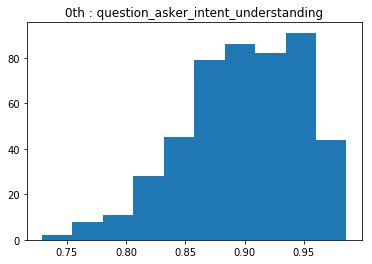

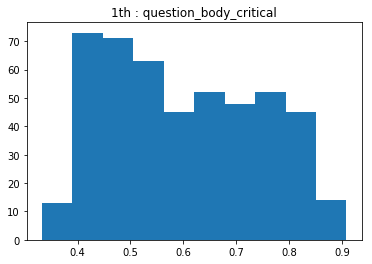

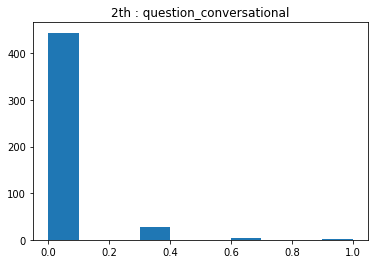

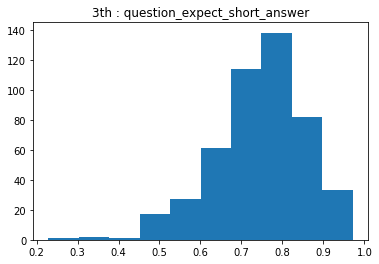

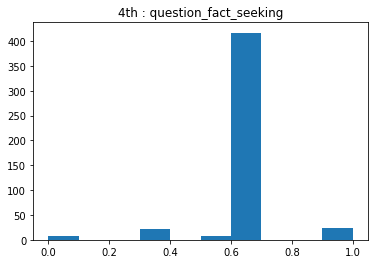

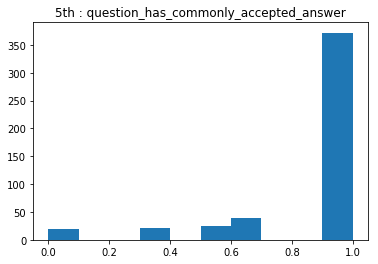

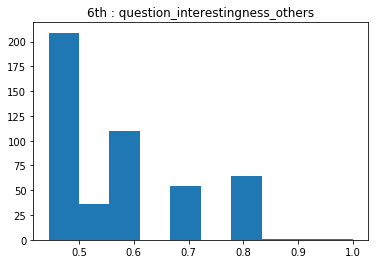

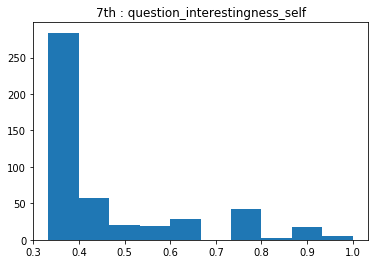

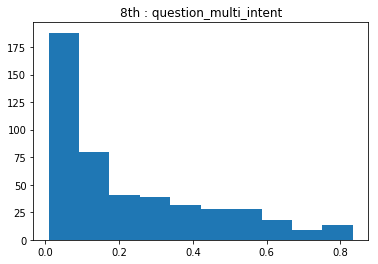

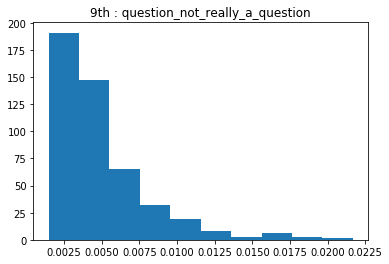

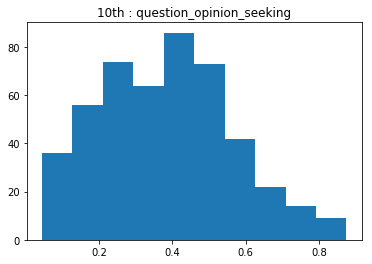

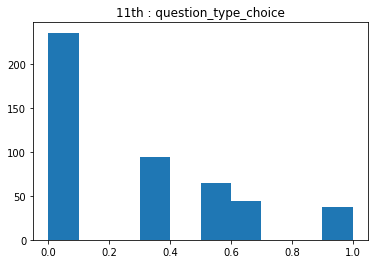

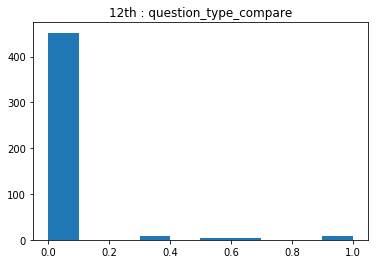

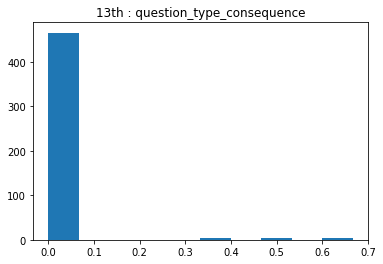

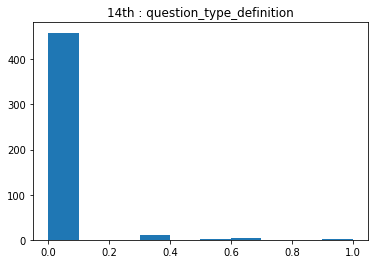

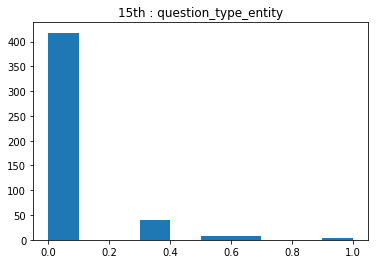

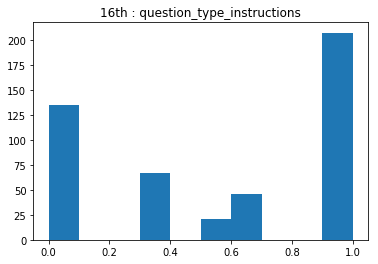

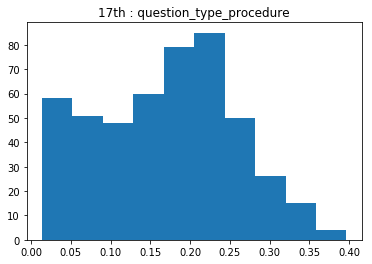

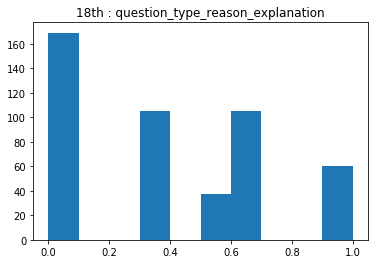

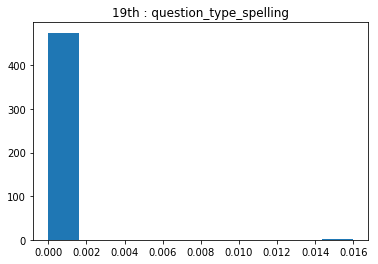

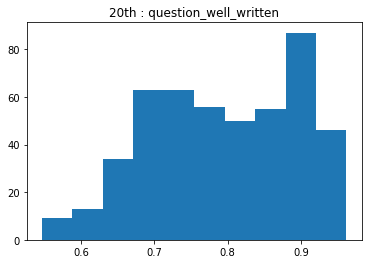

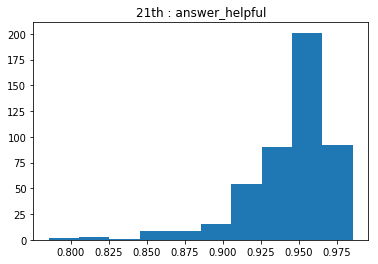

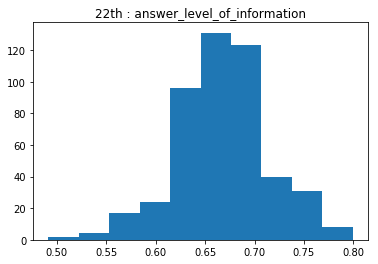

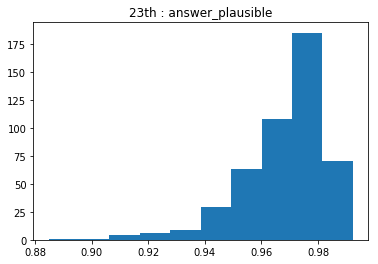

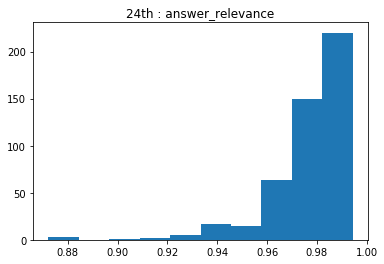

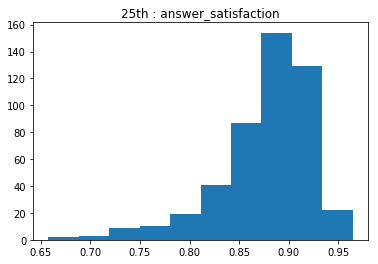

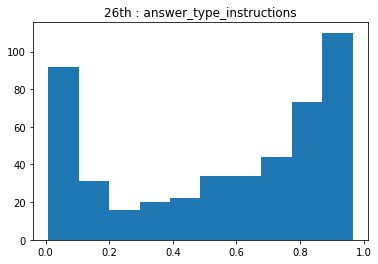

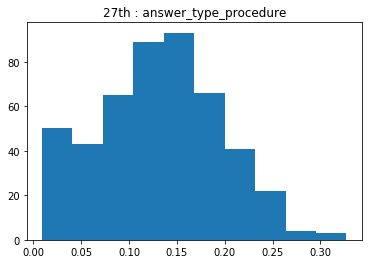

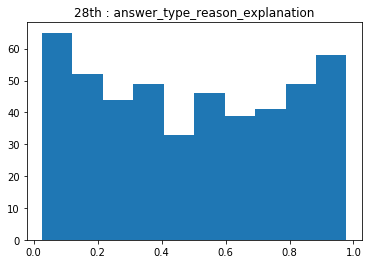

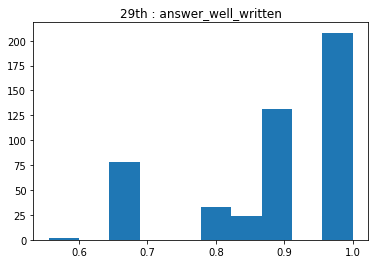

In [29]:
for i in range(30):
    plt.hist(sub_df.iloc[:, i+1])
    plt.title(f'{i}th : {sub_df.columns[i+1]}')
    plt.show()

In [30]:
sub_df.to_csv("submission.csv", index=False)